# Style Transfer - Adding spatial co occurences to the style loss

This notebook was inspired by the following paper: 
[Incorporating Long Range Consistency in CNN based Texture Generation](https://arxiv.org/pdf/1606.01286.pdf)

In [1]:
% matplotlib inline

import numpy as np 

import matplotlib.pyplot as plt

import scipy
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from VGG16 import VGG16

from keras.models import Model

from keras import backend as K

from PIL import Image


Using TensorFlow backend.


In [2]:
def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

In [3]:
limit_mem()

This is a handy function which turns tensors to arrays, to check if everything is working. 

In [4]:
def print_numpy(tens, print_output = False):
    with K.tf.Session() as sess: 
        coord = K.tf.train.Coordinator()
        threads = K.tf.train.start_queue_runners(sess=sess, coord=coord)
        sess.run(K.tf.global_variables_initializer())
        array = tens.eval()
        if print_output:
            print (array)
        return array

## Loading the data

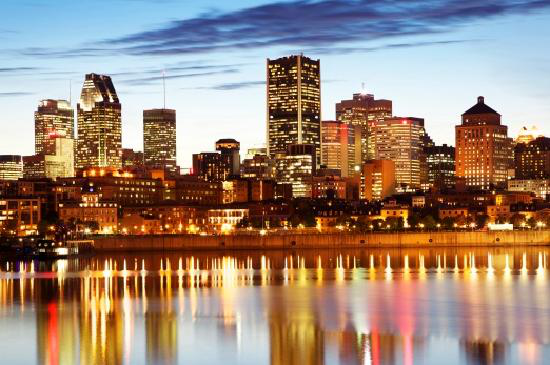

In [5]:
content = Image.open('images/inputs/content/downtown-montreal.jpg')
content

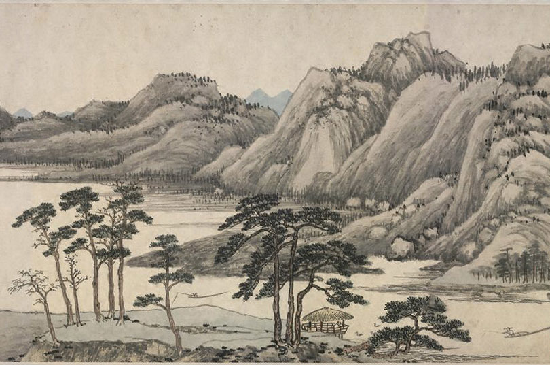

In [6]:
style = Image.open('images/inputs/style/fuchun-mountains.jpg').resize(content.size)
style

## Preprocessing the Images

In [7]:
def image_preprocess(img_ar):
    '''
    Input: image as numpy array
    Output: preprocessed image as numpy array
    '''
    resnet_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
    exp_img_ar = np.expand_dims(np.array(img_ar), 0)
    proc_img_ar = (exp_img_ar - resnet_mean)[:,:,:,::-1]
    return proc_img_ar
#end

def image_postprocess(img_ar, shp):
    '''Input: preprocessed image as numpy array
       Output: postprocessed image as numpy array
    '''
    resnet_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
    postpr_img_ar = np.clip(img_ar.reshape(shp)[:,:,:,::-1] + resnet_mean, 0, 255)
    return postpr_img_ar
#end

In [8]:
content_array = image_preprocess(content)

In [9]:
style_array = image_preprocess(style)

In [10]:
image_array_shape = content_array.shape

## Defining the loss functions

The insight of the paper was to spatially transform the outputs of the layers before calculating their gram matrices, in both the x and y directions. 

I therefore added two methods, which can calculated the 'shifted' gram matrices in both directions. 

In [28]:
def gram_xcc(x, pixel_shift = 4):
    # First, we want to only take part of the x locations
    
    x_positive_shift = K.tf.gather(x, K.tf.range(0, x.shape[0]-pixel_shift))
    x_negative_shift = K.tf.gather(x, K.tf.range(pixel_shift, x.shape[0]))
    
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features_positive_shift = K.batch_flatten(K.permute_dimensions(x_positive_shift, (2, 0, 1)))
    features_negative_shift = K.batch_flatten(K.permute_dimensions(x_negative_shift, (2, 0, 1)))
    
    # Now, I want to 'shift' the features tensor, by deleting pixels from opposite sides
    
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features_positive_shift, K.transpose(features_negative_shift)) / x_positive_shift.get_shape().num_elements()

In [29]:
def gram_ycc(x, pixel_shift = 4):
    x_positive_shift = x[:, pixel_shift:, :]
    x_negative_shift = x[:, :x.shape[1] - pixel_shift, :]
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features_positive_shift = K.batch_flatten(K.permute_dimensions(x_positive_shift, (2, 0, 1)))
    features_negative_shift = K.batch_flatten(K.permute_dimensions(x_negative_shift, (2, 0, 1)))
    
    # Now, I want to 'shift' the features tensor, by deleting pixels from opposite sides
    
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features_positive_shift, K.transpose(features_negative_shift)) / x_positive_shift.get_shape().num_elements()

The gram matrices in both directions are then added together to find the loss function

In [14]:
def cc_loss(computed, target):
    if isinstance(computed, list):
        x_loss = sum([K.sum(metrics.mse(gram_xcc(comp[0]), gram_xcc(targ[0]))) 
                      for comp, targ in zip(computed, target)])
        y_loss = sum([K.sum(metrics.mse(gram_ycc(comp[0]), gram_ycc(targ[0]))) 
                      for comp, targ in zip(computed, target)])
        s_loss = K.tf.multiply(0.5, K.tf.add(x_loss, y_loss))
    else:
        x_loss = K.sum(metrics.mse(gram_xcc(computed), gram_xcc(target)))
        y_loss = K.sum(metrics.mse(gram_ycc(computed), gram_ycc(target)))
        s_loss = K.tf.multiply(0.5, K.tf.add(x_loss, y_loss))
        #_, height, width, channels = K.int_shape(computed)
    return s_loss

## Getting the targets

In [15]:
def get_style_targets(style_transfer_model, style_ar):
    '''Input: style transfer model and numpy array of the style image
       Output: the output of the model at the style layer(s) and its respective target
    '''
    layer_output_dc = {l.name: l.get_output_at(0) for l in style_transfer_model.layers}
    
    # This style_layer_ls is just a placeholder
    style_layer_ls = [layer_output_dc['block{}_conv2'.format(o)] for o in range(1,6)] #change it different layers if necessary
    style_model = Model(style_transfer_model.input, style_layer_ls)
    style_targ_ls = [K.variable(o) for o in style_model.predict(style_ar)]
    return style_layer_ls, style_targ_ls
#end 

In [16]:
class Evaluator(object):
    '''
    Initialization: function and shape of the image array
    Returns the loss and the gradients as computed with
       respect to the image that is fed to the CNN
    '''
    def __init__(self, f, shp):
        self.f = f
        self.shp = shp
        return
    #end        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)
    #end
    def grads(self, x): 
        return self.grad_values.flatten().astype(np.float64)
    #end    
#end

In [17]:
transfer_model = VGG16(pooling = 'Average', include_top =False, input_shape = image_array_shape[1:])

In [19]:
style_layer_ls, style_targ_ls = get_style_targets(transfer_model, style_array)

In [22]:
loss = cc_loss(style_layer_ls, style_targ_ls)
grads = K.gradients(loss, transfer_model.input)
style_fn = K.function([transfer_model.input], [loss]+grads)
evaluator = Evaluator(style_fn, image_array_shape)

Testing this loss method

In [23]:
def apply_transfer(eval_obj, n_iter, img, shp, path='./', pref='', save=True, verbose=True):
    '''
    Input: evaluator, number of iterations, input image and shape
    Output: final image, list of losses and info dictionary of optimization procedure
    '''
    info_dc = dict()
    loss_ls = list()
    for it in range(n_iter):
        img, min_val, iter_dc = fmin_l_bfgs_b(eval_obj.loss, img.flatten(),
                                              fprime=eval_obj.grads, maxfun=20, iprint = 1)
        img = np.clip(img, -127, 127)
        info_dc['iteration_'+str(it+1)] = iter_dc
        loss_ls = loss_ls + [min_val]
        if verbose:
            print('Current loss value:', min_val)
        #end
        if save:
            imsave(path + pref + 'res_at_iteration_' + str(it+1) + '.png', image_postprocess(img.copy(), shp)[0])
        #end
    #end
    return img, loss_ls, info_dc
#end

Starting with random noise

In [24]:
virgin_img = np.random.uniform(-2.5, 2.5, image_array_shape)/100

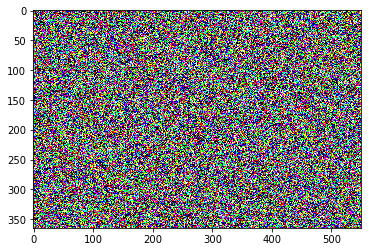

In [25]:
plt.imshow(virgin_img[0])

In [30]:
iterations = 10

image, t_loss, info_dc = apply_transfer(evaluator, iterations, virgin_img, image_array_shape, path='images/cc_test/')

Current loss value: 1348988.5
Current loss value: 258035.625
Current loss value: 93183.75
Current loss value: 36070.2265625
Current loss value: 13384.9628906
Current loss value: 7230.22460938
Current loss value: 4731.02539062
Current loss value: 3503.32885742
Current loss value: 2688.37597656
Current loss value: 2231.69604492


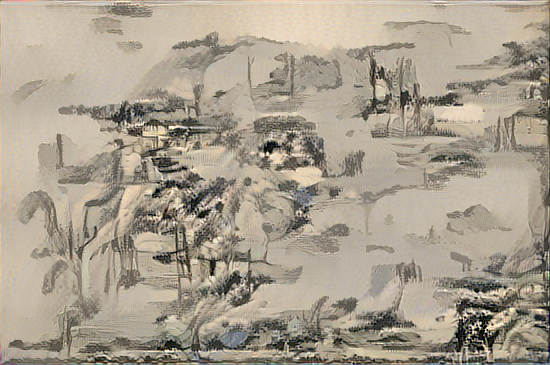

In [31]:
Image.open('images/cc_test/res_at_iteration_10.png')

Not bad! However, this is only half the implementation; the actual paper still couples this with the original gramian loss. 

#### Adding the original gram matrix loss

In [32]:
def gram_matrix(tens):
    features = K.batch_flatten(K.permute_dimensions(tens, (2, 0, 1))) # rows = channels, columns = flattened x, y
    gram = K.dot(features, K.transpose(features)) / tens.get_shape().num_elements() #correlate each pair of channels
    return gram
#end

def style_loss(computed, target, weight_ls=None):
    '''
    Input: computed and target tensors (or lists of tensors for more than one style layer)
    Output: content loss calculated as MSE of the Gram matrices and scaled by the tensor(s) dimension
    '''
    if isinstance(computed, list):
        if not weight_ls:
            weight_ls = [1.0 for layer in computed]
        #end
        s_loss = sum([K.sum(metrics.mse(gram_matrix(comp[0]), gram_matrix(targ[0]))) * w \
                      for comp, targ, w in zip(computed, target, weight_ls)])
        _, height, width, channels = map(lambda i: i, K.int_shape(computed[0]))
    else:
        s_loss = K.sum(metrics.mse(gram_matrix(computed), gram_matrix(target)))
        _, height, width, channels = K.int_shape(computed)
    #end
    s_loss = s_loss #/ (height * width * channels)
    return s_loss

In [33]:
loss = (cc_loss(style_layer_ls, style_targ_ls)/2) + style_loss(style_layer_ls, style_targ_ls)
grads = K.gradients(loss, transfer_model.input)
style_fn = K.function([transfer_model.input], [loss]+grads)
evaluator = Evaluator(style_fn, image_array_shape)

In [34]:
iterations = 10

image, t_loss, info_dc = apply_transfer(evaluator, iterations, virgin_img, image_array_shape, path='images/cc_gram_test/')

Current loss value: 2049043.375
Current loss value: 493862.4375
Current loss value: 192447.375
Current loss value: 95647.6015625
Current loss value: 37166.8515625
Current loss value: 18063.9492188
Current loss value: 11047.109375
Current loss value: 7747.77636719
Current loss value: 5735.6796875
Current loss value: 4561.55419922


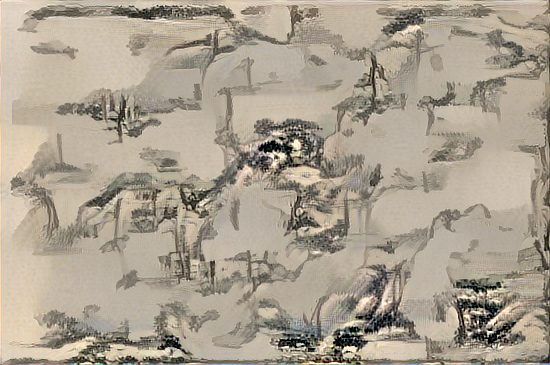

In [35]:
Image.open('images/cc_gram_test/res_at_iteration_10.png')

Wow! This is actually very cool! 